# jif3D Tutorial 1 - create a gravity data file and mesh, run an inversion 

The goal of this first tutorial is to introduce some fundamental concepts when performing inversion or joint inversion with jif3D. In particular we will focus on the underlying coordinate system conventions, how to read in data from an ascii file and how to convert it to a format suitable for jif3D.
## Coordinate system conventions
In jif3D all modelling and inversion is performed in a cartesian coordinate system and with rectilinear meshes. This type of inversion is geared towards local and regional investigations on the scale of hundreds of meters to a few hundred kilometers. In most cases, however, geophysical data are provided in a spherical coordinate system based on latitude and longitude. Thus one of the first steps we have to perform is to convert latitude/longitude to local cartesian coordinates.

The coordinate system used in jif3D uses the convention **x-axis positive north (Northing)**, **y-axis positive East (Easting)**, **z-axis positive down (Depth)**. It is therefore closely related to the UTM coordinate system albeit in a different order (UTM usually reports Easting first). This convention applies both to coordinates for measurements and for the axes of the inversion meshes and is consistent for all types of data and meshes. In order to avoid ambiguities, we use a convention where data coordinates are named by the corresponding axis, e.g. *MeasPosX* for the measurement position in the x-direction (North), and model coordinates are named after the direction, e.g. *Northing* for the values along the x-axis.

We still start with an example using gravity data from the North-Western United States around the Yellowstone hotspot and the Snake river plane. We use combined satellite and terrestial data from the XGM2019 model (http://icgem.gfz-potsdam.de/calcgrid) on a regular grid with a spacing of 0.1 degrees. The data have been corrected for topography based on a simple Bouguer calculation (gravity_anomaly_bg) and are calculated on the ellipsoid. While some more sophisticated considerations of topography etc. might be needed in some cases, for this example we assume that this correction is sufficient and all data are located at 0 m elevation.

For the creation of model files we use numpy for general handling of array data and reading ascii data.
The conversion from latitude to longitude is performed with pyproj and netCDF4 is to create the input data 
and model files for jif3D. Finally we import matplotlib to create some model and data plots.

In [1]:
import numpy as np
from pyproj import Proj
from netCDF4 import Dataset
import matplotlib.pyplot as plt

We read in the data as provided by the ICGEM data service. The first 40 lines only contain metadata on the
correction, the underlying gravity model etc. For this example we will not look at them. The second line specifies
the transformation from lat/lon to cartesian in the syntax of the well known proj4 (https://proj.org/) utility. We project to Northing/Easting values in UTM Zone 10t. Other transformations can be used. However, we have good experience with UTM based conversions as these are in actual m. Depending on the size of the region under consideration, all transformations will result in some form of distortion when projecting from spherical to cartesian geometry. For regions larger than a few hundred kilometers this can become problematic and the impact on the inversion results needs to be investigated. 

In [2]:
xgm2019 = np.genfromtxt("XGM2019e_2159_88c334f29f64a58a5483172e590b12b3cc713976f8ef51cf06781042440dfd9d.gdf",skip_header=40)

myProj = Proj("+proj=utm +zone=10t, +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

The ascii file contains three columns, longitude, latitude and gravity anomaly in mGal. First we perform the projection keeping in mind that the y-axis in jif3D points East, i.e. it corresponds to the longitudinal information (Easting) which is returned first by the conversion routine. We assign a Z-coordinate (MeasZ) of -0.3 m to all measurements (30cm above the ground, remeber positive down). The main reason for this is to avoid numerical issues in the calculation of the gravity field. In principle the measurement points can be located anywhere, e.g. below the surface , high up in the air or even far away from the gridded area. If the location falls exactly on a cell boundary though, the equations to calculate gravitational acceleration have a singularity (see Li, X., his avoids any numerical issues associated with the singularities.
## Data units
jif3D uses the SI unit system even in cases where common geophysical alternatives are established. For this reason gravitational acceleration is specified in $m/s^2$ instead of the commonly used mGal which are also the values provided by ICGEM. We therefore multipy all acceleration values by $10^{-5}$. Together with the data we also have to provide an error estimate for each measurements. This information is critical to judge the quality of the fit for the final inversion models. Only if this model fits all aspects of the data to a degree that is compatible with the uncertainty, can we have any confidence in the results. Unfortunately the values are provided without any uncertainy estimates. We therefore assign a nominal error of $10^{-5}$ $m/s^2$ to each datum. We can adjust the effective error used in the inversion when providing input parameters to actual inversion run.

## Anomaly inversion
Gravity measurements are relative, i.e. they are typically made with respect to reference point. For this reason we cannot retrieve absolute density values within the Earth from regional gravity data. For this reason I typically invert for gravity anomalies, i.e. the deviation of density from a background value. Depending on the size of the region and the depth of interest, one might also want to remove effects from "deep" source, e.g. changes in Moho thickness, lithospheric thickness etc. For this simple example, we subtract the mean value from the data, so that they vary symetrically around zero. While not perfect, it appears to work reasonably well in many cases.

In [3]:
#Project from lat/lon to Easting/Northing
MeasY, MeasX = myProj(xgm2019[:,0], xgm2019[:,1])
#Measurements are located 30cm above ground
MeasZ = -0.3 * np.ones(MeasX.shape) 
#convert data from mGal to m/s2
gz = xgm2019[:,2] * 1e-5
#set a global error of 10^-5 m/s2
dgz = np.ones(gz.shape) * 1e-5
#subtract mean from data to retrieve anomalies
mgz = gz - np.mean(gz)

In many cases we are provided with a dataset and want to invert all available data for an Earth model. In other cases we want to extract subsets from certain regions for further investigation. Here we restrict the datapoint to a rectangular box in projected coordinates by finding the indices of points that lie between the specified boundaries. 

In [4]:
ind = (MeasX > 4650000) & (MeasX < 5200000) & (MeasY > 950000) & (MeasY < 1500000)

Now we have all the ingredients to produce the NetCDF data file that will be the input for jif3D. NetCDF is a versatile and general scientific data format used in many disciplines (https://www.unidata.ucar.edu/software/netcdf/). It is supported by a variety of programming languages (C++, Fortran, C, python) and scientific programs (Matlab, gmt). To define the NetCDF file for the gravity data we first need to create a so-called dimension, in this case called StationNumber. This dimension is then used to define how many values each array variable in the file has. In principle NetCDF files can contain several dimensions and each variable can use a different subset of dimensions. In our case, the layout for the data is very simple. We have a single dimension and all variables use this one dimension. In addition, each variable also can contain metadata. In our case the only metadata are the units of each variable, m for the three coordinate values (MeasPosX, MeasPosY, MeasPosZ) and m/s2 for the data and error (Scalar_gravity, dGz). jif3D checks that these units are written to the file and does not perform any automatic conversions.

In [5]:
data_fh = Dataset("gravdata.nc", "w")
# The number of stations within the bounds specified above
nstat = MeasX[ind].size
#create a dimension with the corret number of stations
statdim = data_fh.createDimension("StationNumber", nstat)
# create a one-dimensional array variable named MeasPosX of floating point type with a number of
#values specified by the dimension StationNumber
vmeasx = data_fh.createVariable("MeasPosX","f8",("StationNumber"))
#set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
vmeasx[:] = MeasX[ind]
#the other entries follow the same pattern, all are simple arrays with nstat values
vmeasy = data_fh.createVariable("MeasPosY","f8",("StationNumber"))
vmeasy.units = "m"
vmeasy[:] = MeasY[ind]
vmeasz = data_fh.createVariable("MeasPosZ","f8",("StationNumber"))
vmeasz.units = "m"
vmeasz[:] = MeasZ[ind]
vgz = data_fh.createVariable("Scalar_gravity","f8",("StationNumber"))
vgz.units = "m/s2"
vgz[:] = mgz[ind]
vdgz = data_fh.createVariable("dGz","f8",("StationNumber"))
vdgz.units = "m/s2"
vdgz[:] = dgz[ind]
#close the file to make sure everything is written to disk correctly
data_fh.close()

## Making an inversion mesh
Now that we have converted the gravity data to the right format, we can start to think of the corresponding inversion mesh. We generally want to cover the region of the survey and at least some of its surroundings. Many geophysical methods including gravity are sensitive to structures in spherical region around each measurement site. Thus measurements at edges of the survey can be influenced by structures outside the region of interest. Having a padding area around the core region allows the inversion to place structures in this region to accommodate these effects. We also want to cover a depth range that contains all potentially significant structures. This can be tricky as we often want to recover details in the near surface (on the scale we are dealing with here this means the upper few kilometers). If we use a constant vertical cell size this can result in large grids that are computationally expensive to invert and contain unncesseray flexibility at depth. An approach that has been used successfully is to increase the cell size in the vertical direction by a constant factor with each layer. Here we start with cells that are 1,000 m thick at the top and increase by a factor of 1.1, e.g the second layer is 1,100 m thick and so on. The last cells then habe a thickness of more than 15,000 m and the model extends to 164 km.

For this example a mesh of $64 \times 64 \times 30$ cells with horizontal lengths of 10,000 m seems sufficient to cover the region of interest with some extra room around the survey. The distance between individual data points is on the order of 15 km, so it is on the same order as our grid spacing. Depending on the type of data we might want to have a few cells between each measurement (for example for magnetotelluric data) to give the inversion enough flexbility or want to cover each cell with a measurement (for potential field data). In most cases we want to avoid the extremes, i.e. many datapoints located in a single cell or many cells (10 or more) between measurements. In the first case we likely will not be able to fit the data as the inversion cannot vary structures at sufficiently fine scales. In the second case there is a chance that regions between the measurements are not well resolved and structures are dominated by smoothing effects from regularization.

In [6]:
print("Data spacing: ", np.sqrt((MeasX[0]-MeasX[1])**2+(MeasY[0]-MeasY[1])**2))
#set the number of cells in each direction
nx = 64
ny = 64
nz = 30
#set the corresponding cell sizes in m
deltax = 10000.0
deltay = 10000.0
deltaz = 1000.0
#calculate the center position for the measurements
centerx = (np.min(MeasX) +  np.max(MeasX))/2.0
centery = (np.min(MeasY) + np.max(MeasY))/2.0
#calculate the model origin so the center of measurements is in the center of the model
startx = centerx - nx/2 * deltax
starty = centery - ny/2 * deltay
#we do not consider topography here, to we set the top of the model to a nominal elevation of 0
startz = 0.0
#the factor by which we increase layer thickness
increase = 1.1
#calculate the layer thicknesses with depth
#we round to full meters because
# a) it is a bit ridiculous to work with sub meter precision when inverting lithospheric structures
# b) we run into all kinds of floating point precision issues when trying to compare numbers
thick = np.round(deltaz * np.power(increase,np.arange(0,nz)))
#calculate layer depth from thickness
Depth = np.cumsum(thick)
#calculate cell bounbdaries in north direction from specified number of cells and cell size
Northing = np.round(startx + np.cumsum(np.ones(nx)*deltax))
Easting = np.round(starty + np.cumsum(np.ones(ny)*deltay))
print("Thicknesses:", thick)
print("Depth", Depth)

Data spacing:  15233.222282343078
Thicknesses: [ 1000.  1100.  1210.  1331.  1464.  1611.  1772.  1949.  2144.  2358.
  2594.  2853.  3138.  3452.  3797.  4177.  4595.  5054.  5560.  6116.
  6727.  7400.  8140.  8954.  9850. 10835. 11918. 13110. 14421. 15863.]
Depth [  1000.   2100.   3310.   4641.   6105.   7716.   9488.  11437.  13581.
  15939.  18533.  21386.  24524.  27976.  31773.  35950.  40545.  45599.
  51159.  57275.  64002.  71402.  79542.  88496.  98346. 109181. 121099.
 134209. 148630. 164493.]


## Background layers
So we have defined the geometry of our inversion mesh, so two things remain to be done: i) We have to define a starting density for each cell. ii) We need to specify the background density around the central mesh. When working with potential field data in jif3D the core inversion mesh is embedded in a layered background. This can be used to deal with boundary effects or structures outside the region of interest, for example at depth. The layers of this background can be defined independently of the mesh, i.e. we can have less or more background layers and their boundaries do not need to coincide with the mesh boundaries. It is also important to note that the densities in these outside layers are not changed during the inversion, so one has to take care to use appropriate values. Fortunately when using gravity data with zero mean and inverting for density anomalies it should usually be fine to have background layers with an anomalous value of zero. In this case we could also omit the specification of background layers entirely. However, we will define them here to show how this could be done in other cases.
## Starting density
We also need to specify the starting density for each cell in the inversion mesh. There are two approaches that are generally used: i) Set all densities to the same value ii) Construct a model based on available prior information. Option i) is typically employed when we do not know much about an area or we want a "data-driven" approach, i.e. we want the measurements to tell us what the structures are. Option ii) is suitable for areas with rich geological information, if we want to steer the inversion in a certain direction or test a hypothesis. For this example we use a simple homogeneous starting model where the anomalous density is set to zero everywhere. Thus any structures emerging during the inversion will be related to some aspect in the data. 

In [7]:
#create a 3D array of density values filled with zeros
Density = np.zeros([nz,ny,nx])
bg_densities = np.zeros(nz)
bg_thickness = thick


With this setup the specification of the data is generally complete. We perform a quick sanity check to plot the measurements in relationship to the grid. This is very useful to test if the conversion and grid creation has succeeded.

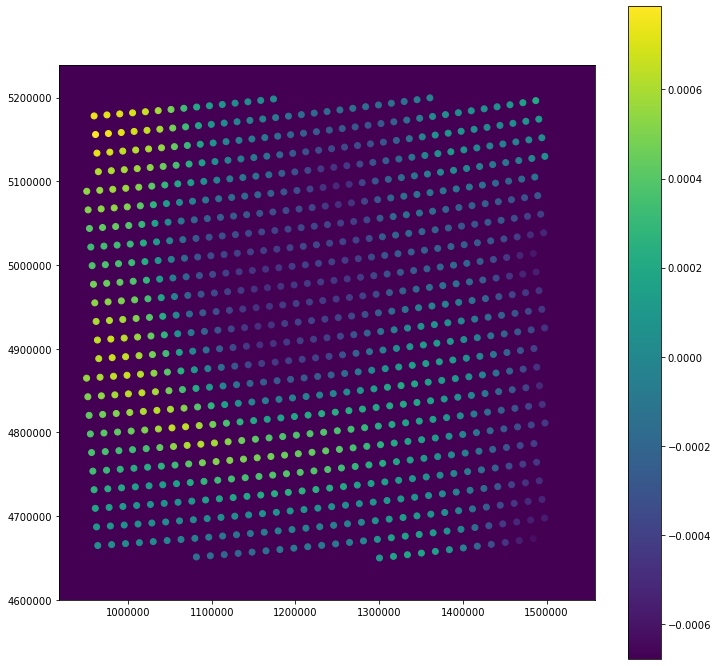

In [8]:
plt.figure(figsize=(12,12))
pn = np.append(startx,Northing)
pe = np.append(starty,Easting)
mx, my = np.meshgrid(pe,pn)
plt.pcolormesh(mx,my,np.transpose(Density[0,:,:]))
plt.scatter(MeasY[ind],MeasX[ind],c=mgz[ind])
plt.xlim([np.min(pe),np.max(pe)])
plt.ylim([np.min(pn),np.max(pn)])
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

We can see that the measurements (colored points) are centered in the grid, there is some padding around the measurement area and the values (remember $m/s^2$) are reasonable and symmetric around zero as expected. We can also see some first order structures in the data, e.g. the high density ring shaped anomaly is related to the Snake River plane. Given that everything looks reasonable we can proceed to creating a grid file in netCDF format.
## Grid file format
The creation of the density starting mesh is done similarly to the data file creation and those with some python and or netCDF experience should be able to read the code below. For those who are just starting I will give a few more explanations.

First we create the dimensions (think of them as grid axes). As we are dealing with a rectilinear 3D mesh, we need to define three directions, *Northing, Easting, Depth* (the positive directions of our coordinate system). We also create a dimension that is used for the background layers (*bg_layers*) as we can have a different amount of background layers as explained above. In principle the background information can also be omitted from the file, then the value is assumed to be zero everywhere around the core mesh.

For each axis we also need an origin value (*Northing_Origin, Easting_Origin, Depth_Origin*), together with the grid cell boundaries in the corresponding array variable, the mesh is completely specified. The first cell will extend from *Northing_Origin* to *Northing[0]*, the second cell from *Northing[0]* to *Northing[1]* and so on for all cells and axes.

The variable *Density* is a 3D array in the index order *Depth, Easting, Northing* and is defined accordingly. Finally we need to set the *units* metadata information which is $m$ for all coordinates and $kg/m^3$ for density.

In [9]:
model_fh = Dataset("start_grav.nc", "w")
Northdim = model_fh.createDimension("Northing", Northing.size)
Eastdim = model_fh.createDimension("Easting", Easting.size)
Depthdim = model_fh.createDimension("Depth", Depth.size)
bgdim = model_fh.createDimension("bg_layers", bg_densities.size)
         
vnorth = model_fh.createVariable("Northing","f8",("Northing"))
vnorth[:] = Northing[:]
vnorth.units = "m"

vnorth_orig = model_fh.createVariable("Northing_Origin","f8")
vnorth_orig[:] = startx
         
veast = model_fh.createVariable("Easting","f8",("Easting"))
veast[:] = Easting[:]
veast.units = "m"
veast_orig = model_fh.createVariable("Easting_Origin","f8")
veast_orig[:] = starty
         
vdepth = model_fh.createVariable("Depth","f8",("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_fh.createVariable("Depth_Origin","f8")
vdepth_orig[:] = startz
         
vdens  = model_fh.createVariable("Density","f8",("Depth","Easting","Northing"))
vdens[:,:,:] = Density[:,:,:]
vdens.units = "kg/m3"
         
vbgdens = model_fh.createVariable("bg_densities","f8",("bg_layers"))
vbgdens[:] = bg_densities[:]
vbgdens.units = "kg/m3"
         
vbgthick = model_fh.createVariable("bg_thicknesses","f8",("bg_layers"))
vbgthick[:] = bg_thickness[:]
vbgthick.units = "m"

model_fh.close()  

## Running a gravity inversion
With a datafile and a meshfile we can run our first inversion. There are various ways to interact with the programs including interactively entering filenames etc. at the command line. This is good for quick experimentation but can become tedious and error prone. Therefore I typically create small shell scripts that supply the necessary information to the program.

For this exercise we use the program *grav_jointinv* which performs joint inversion of standard gravity, full tensor gravity (FTG) and magnetic data. At the moment joint inversion with magnetotelluric or seismic data is performed by a separate program *jointinv* which we will discuss later. We can also us this program for individual inversion of the gravity data (as in this exercise) by setting the weights for the other datasets and for the constraints that couple the datasets to zero.

A typical sequence of inout prompts can look like this:

|  Program output | Explanation  |  
|---|---|
|  Mesh filename: |  Name of the netCDF file containing the cell geometry. |  
|  Scalar Gravimetry Lambda: |  Weight for the standard gravity data (0 means no data) |   
|  FTG Lambda: | Weight for full tensor gravity data (0 means no data) |   
| Scalar Gravity Data Filename: | Name of the netCDF file containing gravity measurements |
| Gravity Model Filename:| Name of the file containing densities, must have identical geometry to mesh |
| Magnetics Lambda: | Weight for magnetic data (0 means no data) |
| Gravity Regularization Lambda: | Weight for smoothness of density in objective function |
| Magnetics Regularization Lambda: | Weight for smoothness of susceptibility in objective function |
| Cross-gradient weight: | Weight for the coupling term |
| Iterations: | Maximum number of iterations, inversion might stop earlier |

The above table is for a case where we only set *Scalar Gravimetry Lambda* to a value greater than zero (usually one) and *FTG lambda* and *Magnetics Lambda:* to zero, i.e. we only want to invert standard gravity data. If those two weights have non-zero values, additional prompts asking for more data filenames and/or models will appear. We will discuss these later.

A few more explanations: The mesh can be a netCDF can be any type used in the joint inversion framework *jif3D* (density, magnetics, MT, seismics) as only the cell geometries are used. It is however important that all subsequent model files have the same mesh geometry. The program should check for this and complain where this assumption is violated. If due to some exotic corner cases a non-conforming mesh passes the check, unpredictable things will happen. We will discuss this in the first joint inversion example.

By default we use a finite difference approximation to the spatial gradient for regularization, i.e. we penalize differences in values between adjacent cells. Higher regularization values will usually result in models with less variations (smoother) and the optimal value has to be determined by trial and error and inspection of the final models. Typical regularization values lie in the range $1 \ldots 10,000$.

The next few lines of python produce a bash script that supplies the inversion with the necessary information. If you are unfamiliar with command line scripting under Linux, there is a wealth of tutorials online.

In [12]:
#location of the jif3D executables on your system
execpath = "/home/max/workspace/jif3D/bin/"
#program we want to run
progname = "grav_jointinv"
#name of the density starting mesh
gravmesh = "start_grav.nc"
#name of the gravity data file
gravdata = "gravdata.nc"
#weight for standard gravity data, typically 1 in individual inversions
gravweight = 1.0
#weight for the magnetic data, set to zero at the moment as we do not have magnetic data yet
magweight = 0.0
#The joint inversion can also handle other types of data but we are not interested in those right now
#so we set the corresponding weights to zero to disable them
magvectorweight = 0.0
mtweight = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
#weight for the FTG data, set to zero at the moment as we do not have FTG data 
ftgweight = 0
#weight for the density regularization, higher values = smoother models
gravregularization = 1000.0
#maximum number of iterations
iterations = 20
#write all information to file
f = open('run', 'w')
f.write(execpath+progname+"<<eof \n")    
f.write(gravmesh+"\n")
f.write(str(gravweight)+"\n")
f.write(str(ftgweight)+"\n")
f.write(gravdata+"\n")
f.write(gravmesh+"\n")
f.write(str(magweight)+"\n")
f.write(str(magvectorweight)+"\n")
f.write(str(mtweight)+"\n")
f.write(str(tomographyweight)+"\n")
f.write(str(surfacewaveweight)+"\n")
f.write(str(gravregularization)+"\n")
f.write(str(iterations)+"\n")
f.write("eof\n")
f.close()

Once the *run* file has been written, we can execute it to start the inversion. Depending on the system this can take a few seconds to minutes. When the program is finished you should see its output.

In [13]:
import subprocess
outfile = open("jif3dgravout.out",'w')
subprocess.run(["bash ./run", ""],stdout=outfile,shell=True)
outfile.close()
log = open("jif3dgravout.out",'r')
for line in log:
    print(line)


Mesh filename: Scalar Gravimetry Lambda: FTG Lambda: Scalar Gravity Data Filename: Gravity Model Filename: Storing sensitivities in memory 

Storing sensitivities on disk 

Scalar Gravity ndata: 836

Scalar Gravity lambda: 1

Magnetics Lambda: Magnetization Lambda: MT Lambda: Tomography Lambda: Surface wave tomography Lambda: Density  Regularization Lambda: Maximum number of iterations: Performing inversion.

                  ScalGrav                 DensityReg 

                    757151                          0 

Runtimes: 

                        11                          0 



Iteration: 0

                  ScalGrav                 DensityReg 

                    757151                          0 

Runtimes: 

                         0                          0 



Individual Grad Norms: 

                    230002                          0 

Runtimes: 

                         0                          0 



                  ScalGrav                 DensityReg 

  

The inversion prints the raw data misfit and the model roughness (regularization) at each iteration to the screen and in this case stops after 13 iterations as the target misfit has been reached, i.e. on average we fit the measurements within the assumed error. This information is useful to understand what is happening during long inversion runs of several hours or days. The same information is also written to output files which are more convenient for analysis when the inversion is finished. The summary information on the raw $\chi^2$ misfit for each part of the objective function is written to *misfit.out*. Our definition is
$$ \chi^2 = \sum_{i=1}^N \frac{(d_{obs} - d_{synth})^2 }{\Delta d_{obs}^2 }, $$
where $N$ is the number of data points $d_{obs}$ the observed data, $d_{synth}$ the synthetic data and $\Delta d_{obs}$ the assumed data uncertainty. This means that when we fit the data within the uncertainty we should have $\chi^2 = N$. For the regularization terms the definition is analogous only that the data difference is replaced by the roughness in each cell and the data uncertainty by a model covariance (more on that later).

While the raw $\chi^2$ misfit is sufficient to evaluate the fit of the models, it is often more convenient to think about the corresponding normalized quantity, RMS, viz.
$$ RMS = \sqrt{\frac{\chi^2}{N}}. $$
This value should be unity for a data fit within the specified uncertainties and for all data terms is written to the file *rms.out*.

In [14]:
misfit = np.genfromtxt("misfit.out")
rms = np.genfromtxt("rms.out")

In our example the *misfit.out* contains 4 columns: iteration number, total misfit (data misfit plus model roughness), gravity data misfit, model roughness, number of forward calculations (mostly for internal benchmarking). *rms.out* only contains three columns: iteration number, data rms and number of forward calculations. Plotting the misfit and model roughness as a function of iteration shows us the evolution of the inversion. 

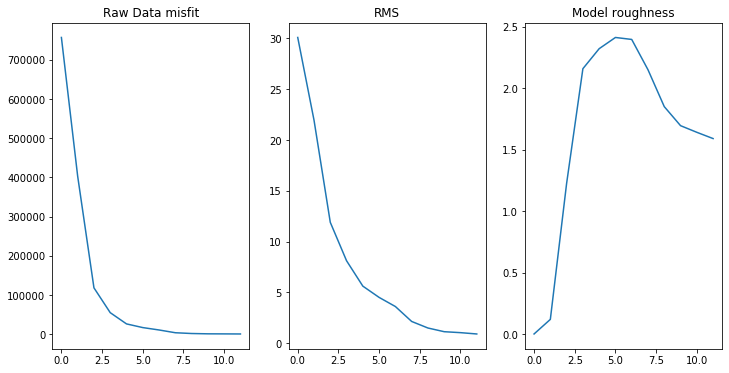

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(misfit[:,2])
plt.title("Raw Data misfit")
plt.subplot(132)
plt.plot(rms[:,1])
plt.title("RMS")
plt.subplot(133)
plt.plot(misfit[:,3])
plt.title("Model roughness")
plt.show()

## Looking at the output
We can see how the raw data misfit and the RMS show the same behaviour, both decrease rapidly in the first few iterations and then convergence slower and slower. This is typical for inversions when they approach the minimum and in some cases this last part can take the most amount of time. We also see how the model roughness steadily increases and then dips before it increases again. This is typically a good sign as it means that the regularization smoothed out some unnecessary structures in the model. As the inversion has coverged to a satisfactory misfit, we can also plot the model.

The inversion outputs a variety of files all starting with *result* and typically in two formats, netCDF in the same form as the input meshes and data and .vtk for visualization with paraview (https://www.paraview.org/). The final gravity model is in the file *result.grav.inv.nc*. As it has the same mesh geometry as our input files we only need to read the density values.

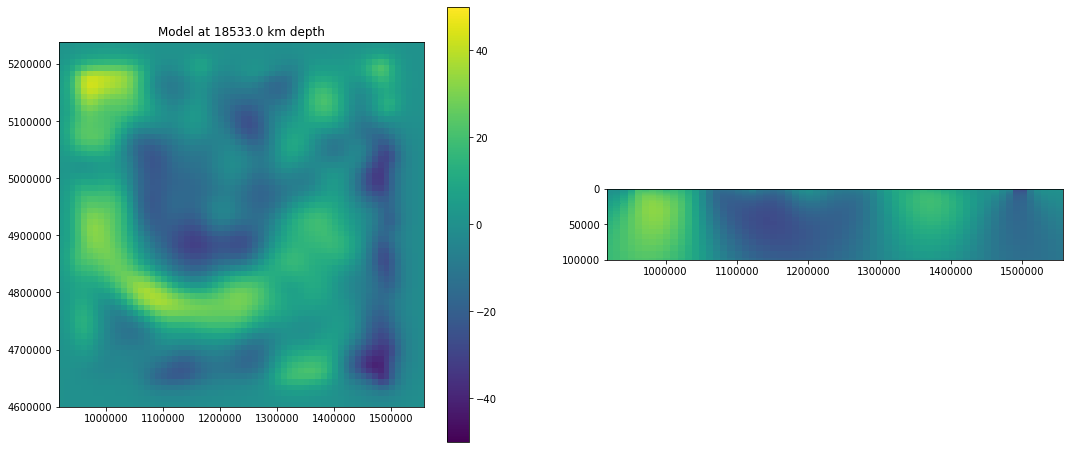

In [16]:
#the index of horizontal layer we want to plot, larger numbers = deeper, maximum 29 (nz-1)
depthindex = 10
#the index of the East-West slice, larger numbers = further north, maximum 63 (nx-1)
northindex = 32
#read in inversion model
grav_fh = Dataset("result.grav.inv.nc")
invdens = grav_fh.variables["Density"][:,:,:]
grav_fh.close()
plt.figure(figsize = (18,8))
plt.subplot(121)
mx, my = np.meshgrid(pe,pn)
#need to transpose here as the array is in order Easting,Northing but we need northing/easting
#for plotting
pdens = np.transpose(invdens[depthindex,:,:])
plt.pcolormesh(mx,my,pdens,vmin=-50,vmax=50)
plt.title("Model at {} km depth".format(Depth[depthindex]))
plt.gca().set_aspect(1)
plt.colorbar()


plt.subplot(122)
pd = np.append(startz,Depth)
mx, my = np.meshgrid(pe,pd)
plt.pcolormesh(mx,my,invdens[:,:,northindex],vmin=-50,vmax=50)
plt.ylim([100000,0])
plt.gca().set_aspect(1)
plt.show()

The horizontal slice (left) and East-West slice (right) show that the model very much looks like our data. In regions of positive gravity anomalies we observe high densities and vice versa. Also, there is little to no depth resolution, all anomalies extend from the surface down to 100 km depth with little variation. Both these phenomena are typical when inverting gravity data in this way. 

We can also read in the predicted gravity data from the inversion model. It is written to the file *result.inv_sgd.nc* (sgd for scalar gravity data) which is organized exactly as our input data file and we are guaranteed that the measurements are witten in the same order. We therefore only read the predicted values and reuse the measurement positions defined above.

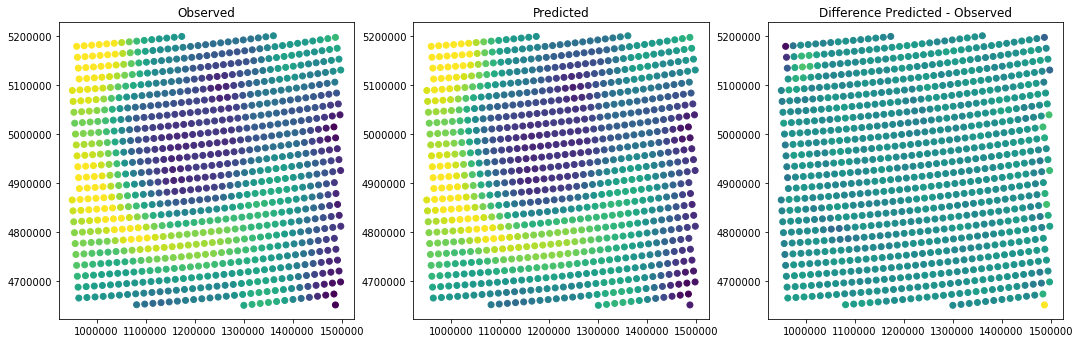

In [17]:
#Read in data calculated from the final model
invdata_fh=Dataset("result.inv_sgd.nc")
invgz = invdata_fh.variables["Scalar_gravity"][:]
invdata_fh.close()

plt.figure(figsize = (18,12))
plt.subplot(131)
plt.scatter(MeasY[ind],MeasX[ind],c=mgz[ind],vmin=-0.0006,vmax=0.0006)
plt.gca().set_aspect(1)
plt.title("Observed")
plt.subplot(132)
plt.scatter(MeasY[ind],MeasX[ind],c=invgz,vmin=-0.0006,vmax=0.0006)
plt.gca().set_aspect(1)
plt.title("Predicted")
plt.subplot(133)
plt.scatter(MeasY[ind],MeasX[ind],c=(invgz-mgz[ind]),vmin=-0.0001,vmax=0.0001)
plt.gca().set_aspect(1)
plt.title("Difference Predicted - Observed")
plt.show()


The above plots show from left to right, the observed gravity data, the predicted gravity data and the difference between the two. We can see that the predicted data match the observations very well and there is no significant mismatch. This is typical for gravity data. With a reasonably fine model we can usually fit all data very well. Still the models lack resolution with depth.
## Tasks

- Change the regularization weight for the inversion to values between 1 and 100,000 (by a factor of ten) and observe how the data fit and the model change
- Change the values for depthindex and northindex in the model plot script and look how the models change with depth and from south to north.
- Optional: Download the final .vtk model file *result.grav.inv.vtk*, load it into paraview and investigate the model there 